## Instalar MCP

## Crear MCP server simple

## Conectar LangGraph con el servidor MCP

In [79]:
import asyncio

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_mcp_adapters.client import MultiServerMCPClient

from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
import os
os.environ["IT_REQUESTS_DB"] = "./it_requests_demo.json"
print("✅ IT_REQUESTS_DB =", os.environ["IT_REQUESTS_DB"])


In [104]:
# 2) Modelo (cambia el provider/modelo a lo que uses en el curso)
load_dotenv()

model = init_chat_model(
    model="claude-sonnet-4-5-20250929",
    model_provider="anthropic",
    api_key=os.getenv("ANTHROPIC_API_KEY"),
    temperature=0
)

In [103]:
# 3) Cliente que utiliza el MCP server
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient

async def get_mcp_tools():
    client = MultiServerMCPClient(
        {
            "it_actions": {
                "command": "python",
                "args": ["./it_actions_mcp_server.py"],
                "transport": "stdio",
            }
        }
    )
    tools = await client.get_tools()
    return tools

tools = await get_mcp_tools()
[tool.name for tool in tools]




['create_it_request', 'get_request_status']

In [ ]:
from langchain.chat_models import init_chat_model
from langchain.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from dotenv import load_dotenv

# Cambia el modelo si quieres (o usa variable de entorno)
load_dotenv()

model = init_chat_model(
    model="claude-sonnet-4-5-20250929",
    model_provider="anthropic",
    api_key=os.getenv("ANTHROPIC_API_KEY"),
    temperature=0
)

SYSTEM = SystemMessage(content=
"""Eres un agente de Help Desk interno.
Tu trabajo NO es resolver todo con texto, sino ejecutar acciones cuando aplique usando tools.

Reglas:
- Si el usuario pide instalar software => usa create_it_request con request_type="software_install".
- Si el usuario no puede entrar a una cuenta / pide reset => request_type="access_reset".
- Si el usuario pide reemplazo de dispositivo => request_type="device_replacement".
- Usa priority="high" si el mensaje sugiere bloqueo crítico (no puede trabajar).
- Usa dedupe_key cuando puedas (por ejemplo, un id de email o conversación).
- Por defecto: dry_run=True salvo que el usuario confirme explícitamente que quiere crear la solicitud.

Después de ejecutar la tool, resume el resultado al usuario e incluye el request_id.
"""
)

def call_model(state: MessagesState):
    # Bind de tools MCP al modelo
    response = model.bind_tools(tools).invoke([SYSTEM] + state["messages"])
    return {"messages": response}

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", tools_condition)
builder.add_edge("tools", "call_model")

graph = builder.compile()
print("✅ Graph compilado")



OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [91]:
# 4) Construir grafo mínimo: modelo -> tools (si aplica) -> modelo
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", tools_condition)
builder.add_edge("tools", "call_model")

TypeError: 'coroutine' object is not iterable

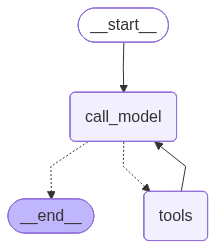

In [ ]:
builder.compile()

## Ejecutar consultas al Graph

In [ ]:
email_id = "MSG-001"

prompt = (
    f"email_id={email_id}\n"
    "Soy ana@empresa.com. Necesito instalar Docker en mi portátil corporativo para un proyecto.\n"
    "¿Puedes abrir la solicitud de IT por mí?"
)

out = await graph.ainvoke({"messages": [HumanMessage(content=prompt)]})
print(out["messages"][-1].content)


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


ToolException: Unknown tool: install_policy